In [23]:
# DATA2001 Week 9 Tutorial
# Material last updated: 26 Apr 2023
# Note: this notebook was designed with the Roboto Condensed font, which can be installed here: https://www.1001fonts.com/roboto-condensed-font.html

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

In [24]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        print(type(geom))
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [25]:
srid = 4326

In [26]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from sqlalchemy import text
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

In [27]:
regions = gpd.read_file('SA2/SA2_2021_AUST_GDA2020.shp')
business = pd.read_csv('Businesses.csv')
stops = pd.read_csv('Stops.txt')
polling_places = pd.read_csv('PollingPlaces2019.csv')
primary = gpd.read_file('catchments/catchments_primary.shp')
secondary = gpd.read_file('catchments/catchments_secondary.shp')
future = gpd.read_file('catchments/catchments_future.shp')
population = pd.read_csv('Population.csv')
income = pd.read_csv('Income.csv')

In [28]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(text(sqlcmd), conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [29]:
db, conn = pgconnect(credentials)

Connected successfully.


In [30]:
sql = """
DROP SCHEMA IF EXISTS assign CASCADE;
CREATE SCHEMA assign;
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [31]:
sql = """
SET search_path TO assign, public;
SELECT PostGIS_version();
"""
query(conn, sql)

,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### Data cleaning of business

In [32]:
business.describe()

,sa2_code,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
count,1.221700e+04,12217.000000,12217.000000,12217.000000,12217.000000,12217.000000,12217.000000,12217.000000
mean,1.149587e+08,18.822870,22.797659,23.555947,2.980110,1.089711,1.282639,70.540313
std,8.810935e+06,51.385349,43.099939,60.411508,14.196956,6.613522,15.953875,175.595935
min,1.010210e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.080112e+08,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,8.000000
50%,1.160113e+08,8.000000,10.000000,10.000000,0.000000,0.000000,0.000000,33.000000
75%,1.220214e+08,20.000000,26.000000,26.000000,3.000000,0.000000,0.000000,80.000000
max,1.999995e+08,3589.000000,1680.000000,3782.000000,811.000000,458.000000,1504.000000,10125.000000


In [33]:
business.head(10)

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
5,A,"Agriculture, Forestry and Fishing",101021610,Googong,0,3,0,0,0,0,3
6,A,"Agriculture, Forestry and Fishing",101021611,Queanbeyan Surrounds,182,80,60,5,0,0,327
7,A,"Agriculture, Forestry and Fishing",101031013,Bombala,65,92,81,6,0,0,246
8,A,"Agriculture, Forestry and Fishing",101031014,Cooma,28,30,36,3,0,3,96
9,A,"Agriculture, Forestry and Fishing",101031015,Cooma Surrounds,91,84,73,0,0,0,251


In [34]:
print("Shape of the data:", business.shape)

Shape of the data: (12217, 11)


In [35]:
business.isnull().values.any()

False

No null values

In [36]:
print(business.groupby('industry_code').size())

industry_code
A    643
B    643
C    643
D    643
E    643
F    643
G    643
H    643
I    643
J    643
K    643
L    643
M    643
N    643
O    643
P    643
Q    643
R    643
S    643
dtype: int64


As we can see we have equal number of each category in our dataset

In [37]:
business.dtypes

industry_code             object
industry_name             object
sa2_code                   int64
sa2_name                  object
0_to_50k_businesses        int64
50k_to_200k_businesses     int64
200k_to_2m_businesses      int64
2m_to_5m_businesses        int64
5m_to_10m_businesses       int64
10m_or_more_businesses     int64
total_businesses           int64
dtype: object

In [38]:
business = business.astype({'industry_code': 'string', 'industry_name' : 'string', 'sa2_name' : 'string'})
business.dtypes

industry_code             string[python]
industry_name             string[python]
sa2_code                           int64
sa2_name                  string[python]
0_to_50k_businesses                int64
50k_to_200k_businesses             int64
200k_to_2m_businesses              int64
2m_to_5m_businesses                int64
5m_to_10m_businesses               int64
10m_or_more_businesses             int64
total_businesses                   int64
dtype: object

In [39]:
business.isna().sum()

industry_code             0
industry_name             0
sa2_code                  0
sa2_name                  0
0_to_50k_businesses       0
50k_to_200k_businesses    0
200k_to_2m_businesses     0
2m_to_5m_businesses       0
5m_to_10m_businesses      0
10m_or_more_businesses    0
total_businesses          0
dtype: int64

In [40]:
business.dtypes

industry_code             string[python]
industry_name             string[python]
sa2_code                           int64
sa2_name                  string[python]
0_to_50k_businesses                int64
50k_to_200k_businesses             int64
200k_to_2m_businesses              int64
2m_to_5m_businesses                int64
5m_to_10m_businesses               int64
10m_or_more_businesses             int64
total_businesses                   int64
dtype: object

In [41]:
business.rename(columns={
    '0_to_50k_businesses': 'from_0_to_50k',
    '50k_to_200k_businesses': 'from_50_to_200k',
    '200k_to_2m_businesses': 'from_200k_to_2m',
    '2m_to_5m_businesses': 'from_2m_to_5m',
    '5m_to_10m_businesses': 'from_5m_to_10m',
    '10m_or_more_businesses': 'from_10m_or_more',
}, inplace=True)

In [42]:
business.columns

Index(['industry_code', 'industry_name', 'sa2_code', 'sa2_name',
       'from_0_to_50k', 'from_50_to_200k', 'from_200k_to_2m', 'from_2m_to_5m',
       'from_5m_to_10m', 'from_10m_or_more', 'total_businesses'],
      dtype='object')

In [43]:
sql = """
DROP TABLE IF EXISTS business CASCADE;
CREATE TABLE business (
    industry_code VARCHAR(5), 
    industry_name VARCHAR(120), 
    sa2_code INTEGER,
    sa2_name VARCHAR(120),
    from_0_to_50k INTEGER,
    from_50_to_200k INTEGER,
    from_200k_to_2m INTEGER,
    from_2m_to_5m INTEGER,
    from_5m_to_10m INTEGER,
    from_10m_or_more INTEGER,
    total_businesses INTEGER
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [44]:
business.to_sql('business', conn, if_exists='append', index=False)
query(conn, "select * from business")

,industry_code,industry_name,sa2_code,sa2_name,from_0_to_50k,from_50_to_200k,from_200k_to_2m,from_2m_to_5m,from_5m_to_10m,from_10m_or_more,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


### Data cleaning of income

In [45]:
income.head()

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2426,50,44246,61745
1,101021008,Karabar,5128,42,62946,67345
2,101021009,Queanbeyan,6778,39,61724,67276
3,101021010,Queanbeyan - East,3360,40,64010,71770
4,101021011,Queanbeyan Region,13502,44,74042,85303


In [46]:
income.dtypes

sa2_code          int64
sa2_name         object
earners          object
median_age       object
median_income    object
mean_income      object
dtype: object

In [47]:
numeric_columns = ['median_age', 'median_income', 'mean_income', 'earners']

In [48]:
for numeric_column in numeric_columns:
    try:   
        income= income.astype({numeric_column: 'float64'})
    except ValueError:
        print("Could not convert column", numeric_column)

Could not convert column median_age
Could not convert column median_income
Could not convert column mean_income
Could not convert column earners


In [49]:
for numeric_column in numeric_columns:
    income[numeric_column] = pd.to_numeric(income[numeric_column], errors='coerce')

income.isna().sum()

sa2_code         0
sa2_name         0
earners          6
median_age       6
median_income    6
mean_income      6
dtype: int64

In [50]:
for numeric_column in numeric_columns:
    try:   
        income= income.astype({numeric_column: 'float64'})
    except ValueError:
        print("Could not convert column", numeric_column)

In [51]:
income = income.dropna()
income.isna().sum()

sa2_code         0
sa2_name         0
earners          0
median_age       0
median_income    0
mean_income      0
dtype: int64

In [52]:
income.dtypes

sa2_code           int64
sa2_name          object
earners          float64
median_age       float64
median_income    float64
mean_income      float64
dtype: object

In [53]:
income = income.astype({'sa2_name' : 'string'})
income.dtypes

sa2_code                  int64
sa2_name         string[python]
earners                 float64
median_age              float64
median_income           float64
mean_income             float64
dtype: object

In [54]:
sql = """
DROP TABLE IF EXISTS income CASCADE;
CREATE TABLE income (
    sa2_code INTEGER,
    sa2_name VARCHAR(120),
    earners FLOAT,
    median_age FLOAT,
    median_income FLOAT,
    mean_income FLOAT
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [55]:
income.to_sql('income', conn, if_exists='append', index=False)
query(conn, "select * from income")

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2426.0,50.0,44246.0,61745.0
1,101021008,Karabar,5128.0,42.0,62946.0,67345.0
2,101021009,Queanbeyan,6778.0,39.0,61724.0,67276.0
3,101021010,Queanbeyan - East,3360.0,40.0,64010.0,71770.0
4,101021011,Queanbeyan Region,13502.0,44.0,74042.0,85303.0
...,...,...,...,...,...,...
565,128021537,Royal National Park,13.0,36.0,38956.0,61645.0
566,128021538,Sutherland - Kirrawee,13698.0,41.0,62453.0,71105.0
567,128021607,Engadine,10335.0,43.0,60914.0,70158.0
568,128021608,Loftus - Yarrawarrah,4498.0,45.0,60469.0,73218.0


### Data cleaning of Population

In [56]:
population.head()

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346


In [57]:
population.dtypes

sa2_code               int64
sa2_name              object
0-4_people             int64
5-9_people             int64
10-14_people           int64
15-19_people           int64
20-24_people           int64
25-29_people           int64
30-34_people           int64
35-39_people           int64
40-44_people           int64
45-49_people           int64
50-54_people           int64
55-59_people           int64
60-64_people           int64
65-69_people           int64
70-74_people           int64
75-79_people           int64
80-84_people           int64
85-and-over_people     int64
total_people           int64
dtype: object

In [58]:
population.isna().sum()

sa2_code              0
sa2_name              0
0-4_people            0
5-9_people            0
10-14_people          0
15-19_people          0
20-24_people          0
25-29_people          0
30-34_people          0
35-39_people          0
40-44_people          0
45-49_people          0
50-54_people          0
55-59_people          0
60-64_people          0
65-69_people          0
70-74_people          0
75-79_people          0
80-84_people          0
85-and-over_people    0
total_people          0
dtype: int64

In [59]:
population = population.astype({'sa2_name' : 'string'})

In [60]:
population.dtypes

sa2_code                       int64
sa2_name              string[python]
0-4_people                     int64
5-9_people                     int64
10-14_people                   int64
15-19_people                   int64
20-24_people                   int64
25-29_people                   int64
30-34_people                   int64
35-39_people                   int64
40-44_people                   int64
45-49_people                   int64
50-54_people                   int64
55-59_people                   int64
60-64_people                   int64
65-69_people                   int64
70-74_people                   int64
75-79_people                   int64
80-84_people                   int64
85-and-over_people             int64
total_people                   int64
dtype: object

In [61]:
population.describe()

,sa2_code,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,40-44_people,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
count,3.730000e+02,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.198861e+08,854.737265,890.718499,873.538874,797.010724,941.506702,1079.378016,1141.667560,1119.305630,974.163539,926.337802,860.184987,814.281501,734.670241,618.152815,541.369973,386.790885,268.656836,278.772118,14101.243968
std,6.504069e+06,457.650405,472.605070,465.615660,413.433206,513.399976,711.167860,719.999852,589.994822,453.460847,421.014390,395.336077,376.967453,352.993590,304.425028,281.331172,217.164521,159.342399,204.291009,6039.862248
min,1.020110e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.170316e+08,524.000000,544.000000,517.000000,485.000000,595.000000,578.000000,636.000000,719.000000,679.000000,645.000000,587.000000,559.000000,492.000000,410.000000,355.000000,237.000000,158.000000,122.000000,10291.000000
50%,1.210117e+08,819.000000,854.000000,861.000000,763.000000,891.000000,984.000000,1047.000000,1101.000000,960.000000,931.000000,845.000000,809.000000,703.000000,589.000000,517.000000,366.000000,260.000000,249.000000,13881.000000
75%,1.250116e+08,1157.000000,1207.000000,1182.000000,1065.000000,1219.000000,1462.000000,1506.000000,1496.000000,1314.000000,1227.000000,1138.000000,1072.000000,988.000000,837.000000,734.000000,524.000000,359.000000,403.000000,18757.000000
max,1.280216e+08,2576.000000,2576.000000,2066.000000,1771.000000,3279.000000,4586.000000,4507.000000,3664.000000,2549.000000,1924.000000,1840.000000,1737.000000,1829.000000,1675.000000,1786.000000,1362.000000,891.000000,1110.000000,25565.000000


In [62]:
# for i in range(2,21):
#     print(population.iloc[:,i].sum())
[population.iloc[:,i].sum() for i in range(2,21)]

[318817,
 332238,
 325830,
 297285,
 351182,
 402608,
 425842,
 417501,
 363363,
 345524,
 320849,
 303727,
 274032,
 230571,
 201931,
 144273,
 100209,
 103982,
 5259764]

[318817, 332238, 325830, 297285, 351182, 402608, 425842, 417501, 363363, 345524, 320849, 303727, 274032, 230571, 201931, 144273, 100209, 103982, 5259764]


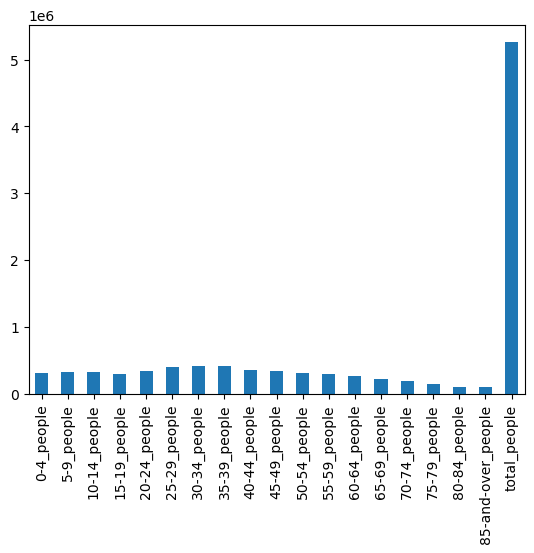

In [63]:
sums = [population.iloc[:,i].sum() for i in range(2,21)]
print(sums)
# Create a histogram of the sums
sums = population.iloc[:,2:21].sum()
sums.plot(kind='bar')
# # Show the plot
plt.show()

In [64]:
population.rename(columns={
    '0-4_people' : 'from_0_to_4',
    '5-9_people' : 'from_5_to_9',
    '10-14_people' : 'from_10_to_14',
    '15-19_people' : 'from_15_to_19',
    '20-24_people' : 'from_20_to_24',
    '25-29_people' : 'from_25_to_29',
    '30-34_people' : 'from_30_to_34',
    '35-39_people' : 'from_35_to_39',
    '40-44_people' : 'from_40_to_44',
    '45-49_people' : 'from_45_to_49',
    '50-54_people' : 'from_50_to_54',
    '55-59_people' : 'from_55_to_59',
    '60-64_people' : 'from_60_to_64',
    '65-69_people' : 'from_65_to_69',
    '70-74_people' : 'from_70_to_74',
    '75-79_people' : 'from_75_to_79',
    '80-84_people' : 'from_80_to_84',
    '85-and-over_people' : 'from_85_and_over'
}, inplace=True)

In [65]:
population.columns

Index(['sa2_code', 'sa2_name', 'from_0_to_4', 'from_5_to_9', 'from_10_to_14',
       'from_15_to_19', 'from_20_to_24', 'from_25_to_29', 'from_30_to_34',
       'from_35_to_39', 'from_40_to_44', 'from_45_to_49', 'from_50_to_54',
       'from_55_to_59', 'from_60_to_64', 'from_65_to_69', 'from_70_to_74',
       'from_75_to_79', 'from_80_to_84', 'from_85_and_over', 'total_people'],
      dtype='object')

In [67]:
sql = """
DROP TABLE IF EXISTS population CASCADE;
CREATE TABLE population (
    sa2_code INTEGER,
    sa2_name VARCHAR(120),
    from_0_to_4 INTEGER,
    from_5_to_9 INTEGER,
    from_10_to_14 INTEGER,
    from_15_to_19 INTEGER,
    from_20_to_24 INTEGER,
    from_25_to_29 INTEGER,
    from_30_to_34 INTEGER,
    from_35_to_39 INTEGER,
    from_40_to_44 INTEGER,
    from_45_to_49 INTEGER,
    from_50_to_54 INTEGER,
    from_55_to_59 INTEGER,
    from_60_to_64 INTEGER,
    from_65_to_69 INTEGER,
    from_70_to_74 INTEGER,
    from_75_to_79 INTEGER,
    from_80_to_84 INTEGER,
    from_85_and_over INTEGER,
    total_people INTEGER
);
"""
query(conn, sql)
population.to_sql('population', conn, if_exists='append', index=False)
query(conn, "select * from population")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,sa2_name,from_0_to_4,from_5_to_9,from_10_to_14,from_15_to_19,from_20_to_24,from_25_to_29,from_30_to_34,from_35_to_39,...,from_45_to_49,from_50_to_54,from_55_to_59,from_60_to_64,from_65_to_69,from_70_to_74,from_75_to_79,from_80_to_84,from_85_and_over,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


### Exploring Polling Places

In [68]:
polling_places.head()

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN


In [69]:
polling_places.shape

(2930, 17)

In [70]:
polling_places.isna().sum()

FID                               0
state                             0
division_id                       0
division_name                     0
polling_place_id                  0
polling_place_type_id             0
polling_place_name                0
premises_name                     0
premises_address_1              193
premises_address_2             2816
premises_address_3             2895
premises_suburb                 115
premises_state_abbreviation       0
premises_post_code              109
latitude                        140
longitude                       140
the_geom                        140
dtype: int64

We can see that columns like "premises_address_3" and "premises_address_2" almost fully populated by Nan values. Thus, we can drop them

In [71]:
polling_places = polling_places.drop(labels=['premises_address_3', 'premises_address_2'], axis=1)


In [72]:
polling_places.isna().sum()

FID                              0
state                            0
division_id                      0
division_name                    0
polling_place_id                 0
polling_place_type_id            0
polling_place_name               0
premises_name                    0
premises_address_1             193
premises_suburb                115
premises_state_abbreviation      0
premises_post_code             109
latitude                       140
longitude                      140
the_geom                       140
dtype: int64

In [73]:
n_rows_with_nan = polling_places.isna().any(axis=1).sum()

# Print the result
print(f"Number of rows with at least one NaN value: {n_rows_with_nan}")

Number of rows with at least one NaN value: 207


In [74]:
pd.concat([polling_places.iloc[0,:],polling_places.dtypes,polling_places.isna().sum()],axis=1)

,0,0,1
FID,aec_federal_election_polling_places_2019.fid-4...,object,0
state,NSW,object,0
division_id,104,int64,0
division_name,Barton,object,0
polling_place_id,33595,int64,0
polling_place_type_id,2,int64,0
polling_place_name,Special Hospital Team 1,object,0
premises_name,Multiple sites,object,0
premises_address_1,NaN,object,193
premises_suburb,NaN,object,115


In [75]:
polling_places =  polling_places.astype({'FID' : 'string', 'state' : 'string', 'division_name' : 'string',
                                         'polling_place_name' : 'string', 'premises_name' : 'string'})

In [76]:
pd.concat([polling_places.iloc[0,:],polling_places.dtypes,polling_places.isna().sum()],axis=1,)

,0,0,1
FID,aec_federal_election_polling_places_2019.fid-4...,string[python],0
state,NSW,string[python],0
division_id,104,int64,0
division_name,Barton,string[python],0
polling_place_id,33595,int64,0
polling_place_type_id,2,int64,0
polling_place_name,Special Hospital Team 1,string[python],0
premises_name,Multiple sites,string[python],0
premises_address_1,NaN,object,193
premises_suburb,NaN,object,115


In [77]:
len(polling_places[polling_places['the_geom'].isna() & polling_places['premises_address_1'].isna()
               & polling_places['premises_suburb'].isna() & polling_places['premises_post_code'].isna()
               & polling_places['latitude'].isna() & polling_places['longitude'].isna()
               & polling_places['the_geom'].isna()])


109

As we can see we have 109 where all these columns have null values, so we can drop these rows

In [78]:
polling_places = polling_places.dropna(subset=['the_geom', 'premises_address_1', 'premises_suburb', 'premises_post_code', 'latitude', 'longitude'], how='all')
len(polling_places[polling_places['the_geom'].isna() & polling_places['premises_address_1'].isna()
               & polling_places['premises_suburb'].isna() & polling_places['premises_post_code'].isna()
               & polling_places['latitude'].isna() & polling_places['longitude'].isna()
               & polling_places['the_geom'].isna()])

0

In [79]:
pd.concat([polling_places.iloc[0,:],polling_places.dtypes,polling_places.isna().sum()],axis=1,)

,3,0,1
FID,aec_federal_election_polling_places_2019.fid-4...,string[python],0
state,NSW,string[python],0
division_id,109,int64,0
division_name,Calare,string[python],0
polling_place_id,33603,int64,0
polling_place_type_id,2,int64,0
polling_place_name,Special Hospital Team 1,string[python],0
premises_name,Multiple sites,string[python],0
premises_address_1,NaN,object,84
premises_suburb,ORANGE,object,6


In [80]:
polling_places.shape

(2821, 15)

We are additionally gonna drop rows where latitude and longitude is null

In [81]:
polling_places = polling_places.dropna(subset=['latitude', 'longitude'], how='all')

In [82]:
pd.concat([polling_places.iloc[0,:],polling_places.dtypes,polling_places.isna().sum()],axis=1,)

,13,0,1
FID,aec_federal_election_polling_places_2019.fid-4...,string[python],0
state,NSW,string[python],0
division_id,103,int64,0
division_name,Banks,string[python],0
polling_place_id,58,int64,0
polling_place_type_id,1,int64,0
polling_place_name,Oatley,string[python],0
premises_name,Oatley Public School,string[python],0
premises_address_1,51 Letitia St,object,67
premises_suburb,OATLEY,object,0


In [83]:
polling_places.shape

(2790, 15)

In [84]:
polling_places[polling_places['premises_address_1'].notna()]

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,OATLEY,NSW,2223.0,-33.98470,151.081000,POINT (-33.9847 151.081)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,DHARRUK,NSW,2770.0,-33.74750,150.817000,POINT (-33.7475 150.817)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,ALLAWAH,NSW,2218.0,-33.97679,151.114897,POINT (-33.9767897 151.1148974)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,SOUTH HURSTVILLE,NSW,2221.0,-33.97560,151.111000,POINT (-33.9756 151.111)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,BEVERLY HILLS,NSW,2209.0,-33.94130,151.075000,POINT (-33.9413 151.075)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,11500,1,Warilla East,Warilla-Barrack Point Surf Life Saving Club,7 Osborne Pde,WARILLA,NSW,2528.0,-34.54950,150.869000,POINT (-34.5495 150.869)
2924,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2810,1,Warilla North,Warilla North Community Centre,2-6 Hill St,WARILLA,NSW,2528.0,-34.54724,150.851770,POINT (-34.54724 150.85177)
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,BARRACK HEIGHTS,NSW,2528.0,-34.56420,150.858000,POINT (-34.5642 150.858)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,WELBY,NSW,2575.0,-34.44090,150.424000,POINT (-34.4409 150.424)


In [85]:
polling_places = polling_places.astype({'premises_address_1' : 'string', 'premises_suburb' : 'string','premises_state_abbreviation' : 'string'})

In [86]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(polling_places.longitude, polling_places.latitude)]
polling_places = polling_places.drop(['latitude','longitude'], axis=1)
polling_places = GeoDataFrame(polling_places, crs="EPSG:4326", geometry=geometry)
polling_places.head()

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_suburb,premises_state_abbreviation,premises_post_code,the_geom,geometry
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,OATLEY,NSW,2223.0,POINT (-33.9847 151.081),POINT (151.08100 -33.98470)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,DHARRUK,NSW,2770.0,POINT (-33.7475 150.817),POINT (150.81700 -33.74750)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,ALLAWAH,NSW,2218.0,POINT (-33.9767897 151.1148974),POINT (151.11490 -33.97679)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,SOUTH HURSTVILLE,NSW,2221.0,POINT (-33.9756 151.111),POINT (151.11100 -33.97560)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,BEVERLY HILLS,NSW,2209.0,POINT (-33.9413 151.075),POINT (151.07500 -33.94130)


We created our own column "geometry that represent the point", so that we have correct type

In [87]:
polling_places = polling_places.drop(['the_geom'], axis=1)
polling_places.head()

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_suburb,premises_state_abbreviation,premises_post_code,geometry
13,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,58,1,Oatley,Oatley Public School,51 Letitia St,OATLEY,NSW,2223.0,POINT (151.08100 -33.98470)
15,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,392,1,Dharruk,Dawson Public School,7 Stuart Rd,DHARRUK,NSW,2770.0,POINT (150.81700 -33.74750)
16,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,31,1,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,ALLAWAH,NSW,2218.0,POINT (151.11490 -33.97679)
17,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,67,1,Allawah South,St Raphael's Church Hall,84 George St,SOUTH HURSTVILLE,NSW,2221.0,POINT (151.11100 -33.97560)
18,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,56500,1,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,BEVERLY HILLS,NSW,2209.0,POINT (151.07500 -33.94130)


In [88]:
polling_places = polling_places.astype({'premises_post_code' : 'int64'})

In [89]:
polling_places.dtypes

FID                            string[python]
state                          string[python]
division_id                             int64
division_name                  string[python]
polling_place_id                        int64
polling_place_type_id                   int64
polling_place_name             string[python]
premises_name                  string[python]
premises_address_1             string[python]
premises_suburb                string[python]
premises_state_abbreviation    string[python]
premises_post_code                      int64
geometry                             geometry
dtype: object

In [90]:
polling_places.rename(columns={'geometry' : 'geom','FID' : 'fid'}, inplace=True)

In [91]:
sql = """
DROP TABLE IF EXISTS polling_places CASCADE;
CREATE TABLE polling_places (
    fid VARCHAR(120),
    state VARCHAR(10),
    division_id INTEGER, 
    division_name VARCHAR(50),
    polling_place_type_id INTEGER,
    polling_place_id INTEGER,
    polling_place_name VARCHAR(120),
    premises_name VARCHAR(120),
    premises_address_1 VARCHAR(120),
    premises_suburb VARCHAR(80),
    premises_state_abbreviation VARCHAR(10),
    premises_post_code INTEGER,
    geom GEOMETRY(POINT,4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [92]:
polling_places['geom'] = polling_places['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

In [93]:
polling_places.to_sql('polling_places', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

790

In [94]:
query(conn, "select * from polling_places")

,fid,state,division_id,division_name,polling_place_type_id,polling_place_id,polling_place_name,premises_name,premises_address_1,premises_suburb,premises_state_abbreviation,premises_post_code,geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,1,58,Oatley,Oatley Public School,51 Letitia St,OATLEY,NSW,2223,0101000020E61000003BDF4F8D97E26240832F4CA60AFE...
1,aec_federal_election_polling_places_2019.fid-4...,NSW,111,Chifley,1,392,Dharruk,Dawson Public School,7 Stuart Rd,DHARRUK,NSW,2770,0101000020E6100000A01A2FDD24DA624048E17A14AEDF...
2,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,1,31,Allawah,PJ Ferry Reserve Community Hall,147B Bellevue Pde,ALLAWAH,NSW,2218,0101000020E6100000A7EC4F3DADE36240EA48E47107FD...
3,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,1,67,Allawah South,St Raphael's Church Hall,84 George St,SOUTH HURSTVILLE,NSW,2221,0101000020E6100000643BDF4F8DE3624022FDF675E0FC...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,103,Banks,1,56500,Beverly Hills North (Banks),Beverly Hills North Public School,1-3 Shorter Ave,BEVERLY HILLS,NSW,2209,0101000020E61000006666666666E26240C6DCB5847CF8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,1,2810,Warilla North,Warilla North Community Centre,2-6 Hill St,WARILLA,NSW,2528,0101000020E6100000D8B628B341DB62401288D7F50B46...
2786,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,1,2809,Warilla South,Warilla High School,10 Keross Ave,BARRACK HEIGHTS,NSW,2528,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2787,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,5,58798,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,None,WARILLA,NSW,2528,0101000020E6100000BD32141C83DB624011F28B5C8146...
2788,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,1,31242,Welby,Welby Community Hall,14 Currockbilly St,WELBY,NSW,2575,0101000020E610000021B0726891CD6240386744696F38...


### Stops

In [95]:
stops = stops.drop(['platform_code'], axis = 1)

In [96]:
stops.head(20)
stops['stop_id'] = pd.to_numeric(stops['stop_id'], errors='coerce')
stops['stop_code'] = pd.to_numeric(stops['stop_code'], errors='coerce')
temp = stops[stops['stop_code'].notna() & stops['stop_id'].notna()]
temp[temp['stop_id'].astype(int) != temp['stop_code'].astype(int)].head(5)
#stops[stops['stop_id'].astype(float).astype(string) != stops['stop_code'].astype(string)].head(5)

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding


In [97]:
stops.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding
0,200039.0,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0
1,200054.0,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0
2,200060.0,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0
3,201510.0,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0
4,201646.0,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0


In [98]:
stops = stops.drop('stop_code', axis = 1)
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding
0,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0
1,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0
2,200060.0,Central Station,-33.884084,151.206292,1.0,NaN,0
3,201510.0,Redfern Station,-33.891690,151.198866,1.0,NaN,0
4,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0


In [99]:
stops = stops.dropna(subset=['stop_id'])
stops['stop_id'].isnull().sum()

0

In [100]:
stops = stops.drop('location_type', axis = 1)

In [101]:
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,parent_station,wheelchair_boarding
0,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,200060,0
1,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,200060,0
2,200060.0,Central Station,-33.884084,151.206292,NaN,0
3,201510.0,Redfern Station,-33.891690,151.198866,NaN,0
4,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,201510,0


In [102]:
stops['parent_station'] = pd.to_numeric(stops['parent_station'], errors='coerce')
stops['parent_station'].isnull().sum()


59322

In [103]:
stops = stops.drop('parent_station', axis = 1)
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,wheelchair_boarding
0,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,0
1,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,0
2,200060.0,Central Station,-33.884084,151.206292,0
3,201510.0,Redfern Station,-33.891690,151.198866,0
4,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,0


In [104]:
stops = stops.astype({'stop_id' : 'int64', 'stop_name' : 'string', 'stop_lat' : 'float64', 'stop_lon' : 'float64',
                        'wheelchair_boarding' : 'int64'})

In [105]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(stops.stop_lon, stops.stop_lat)]
stops = stops.drop(['stop_lat','stop_lon'], axis=1)
stops = GeoDataFrame(stops, crs="EPSG:4326", geometry=geometry)
stops.head()

,stop_id,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",0,POINT (151.20666 -33.88221)
1,200054,"Central Station, Eddy Av, Stand D",0,POINT (151.20699 -33.88204)
2,200060,Central Station,0,POINT (151.20629 -33.88408)
3,201510,Redfern Station,0,POINT (151.19887 -33.89169)
4,201646,"Redfern Station, Gibbons St, Stand B",0,POINT (151.19888 -33.89333)


In [106]:
stops.columns

Index(['stop_id', 'stop_name', 'wheelchair_boarding', 'geometry'], dtype='object')

In [107]:
stops.head()

,stop_id,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",0,POINT (151.20666 -33.88221)
1,200054,"Central Station, Eddy Av, Stand D",0,POINT (151.20699 -33.88204)
2,200060,Central Station,0,POINT (151.20629 -33.88408)
3,201510,Redfern Station,0,POINT (151.19887 -33.89169)
4,201646,"Redfern Station, Gibbons St, Stand B",0,POINT (151.19888 -33.89333)


In [108]:
stops['geometry'] = stops['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))

/Users/yaraslauivashynka/miniconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [109]:
sql = """
DROP TABLE IF EXISTS stops CASCADE;
CREATE TABLE stops (
    "stop_id" INTEGER PRIMARY KEY,
    "stop_name" VARCHAR(100),
    "wheelchair_boarding" INTEGER,
    "geometry" GEOMETRY(POINT,4326)
    
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [110]:
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geometry': Geometry('POINT', srid)})


273

In [111]:
query(conn, "select * from stops")

,stop_id,stop_name,wheelchair_boarding,geometry
0,200039,"Central Station, Eddy Av, Stand A",0,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,"Central Station, Eddy Av, Stand D",0,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,Central Station,0,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,Redfern Station,0,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,"Redfern Station, Gibbons St, Stand B",0,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...
61268,212753,"Sydney Olympic Park Wharf, Side B",1,0101000020E6100000AF9B3D8185E262408F52D7D537E9...
61269,2137185,"Cabarita Wharf, Side A",1,0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...
61270,2137186,"Cabarita Wharf, Side B",1,0101000020E6100000C4F9BEA2BDE362403EB375529EEB...
61271,21501,Parramatta Wharf,1,0101000020E6100000E443E4A456E0624025C1A4032EE8...


### Regions

In [112]:
regions['SA2_CODE21'] = pd.to_numeric(regions['SA2_CODE21'], errors='coerce')
regions = regions.dropna()
regions = regions.astype({'SA2_CODE21' : 'int64', 'SA2_NAME21' : 'string', 'CHG_FLAG21' : 'int64', 'CHG_LBL21' : 'string', 
                          'SA3_CODE21' : 'int64', 'SA3_NAME21' : 'string', 'SA4_CODE21' : 'int64', 'SA4_NAME21' : 'string',
                          'GCC_CODE21' : 'string', 'GCC_NAME21' : 'string', 'STE_CODE21' : 'int64', 'STE_NAME21' : 'string',
                          'AUS_CODE21' : 'string', 'AUS_NAME21' : 'string', 'LOCI_URI21' : 'string', 'AREASQKM21' : 'float64'})


In [113]:
regions.rename(columns={'SA2_CODE21' : 'sa2_code', 'SA2_NAME21': 'sa2_name', 'CHG_FLAG21':'chg_flag', 'CHG_LBL21':'chg_lbl', 'STE_CODE21':'ste_code', 'STE_NAME21':'ste_name',
                        'AUS_CODE21':'aus_code', 'AUS_NAME21':'aus_name', 'LOCI_URI21':'loci_uri',
                        'SA3_CODE21' : 'sa3_code', 'SA3_NAME21' : 'sa3_name', 'SA4_CODE21' : 'sa4_code', 'SA4_NAME21' : 'sa4_name',
                        'GCC_CODE21' : 'gcc_code', 'GCC_NAME21' : 'gcc_name', 'STE_CODE16' : 'ste_code', 'STE_NAME16' : 'ste_name',
                        'AREASQKM21' : 'area_sqkm', 'geometry':'geom'}, inplace=True)
regions.dtypes

sa2_code              int64
sa2_name     string[python]
chg_flag              int64
chg_lbl      string[python]
sa3_code              int64
sa3_name     string[python]
sa4_code              int64
sa4_name     string[python]
gcc_code     string[python]
gcc_name     string[python]
ste_code              int64
ste_name     string[python]
aus_code     string[python]
aus_name     string[python]
area_sqkm           float64
loci_uri     string[python]
geom               geometry
dtype: object

In [114]:
sql = """
DROP TABLE IF EXISTS regions CASCADE;
CREATE TABLE regions (
    "sa2_code" INTEGER,
    "sa2_name" VARCHAR(100),
    "chg_flag" INTEGER,
    "chg_lbl" VARCHAR(100),
    "sa3_code" INTEGER,
    "sa3_name" VARCHAR(100),
    "sa4_code" INTEGER,
    "sa4_name" VARCHAR(100),
    "gcc_code" VARCHAR(100),
    "gcc_name" VARCHAR(100),
    "ste_code" INTEGER,
    "ste_name" VARCHAR(100),
    "aus_code" VARCHAR(100),
    "aus_name" VARCHAR(100),
    "area_sqkm" FLOAT,
    "loci_uri" VARCHAR(150),
    "geom" GEOMETRY(MULTIPOLYGON, 4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [115]:
regions['geom'] = regions['geom'].apply(lambda x: create_wkt_element(geom = x, srid =srid))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'sha

In [116]:
regions.to_sql('regions', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

454

In [117]:
query(conn, "SELECT count(*) FROM population where total_people < 100")

,count
0,13


Filtering popluation dataset to the regions where we have more than 100 inhabitants 

In [118]:
sql = """
DELETE FROM population
WHERE total_people < 100;
SELECT count(*) FROM population where total_people < 100;
"""
query(conn, sql)

,count
0,0


In [119]:
sql = """
SELECT DISTINCT(gcc_name)
FROM regions
"""
query(conn, sql)

,gcc_name
0,Rest of Tas.
1,Greater Brisbane
2,Rest of Vic.
3,Rest of NSW
4,Greater Adelaide
5,Other Territories
6,Greater Darwin
7,Rest of NT
8,Australian Capital Territory
9,Rest of SA


Filtering down to only Greater SYDNEY area

In [120]:
sql = """
DELETE FROM regions
WHERE gcc_name <> 'Greater Sydney'
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [121]:
sql = """
SELECT DISTINCT(gcc_name)
FROM regions
"""
query(conn, sql)

,gcc_name
0,Greater Sydney


### Primary

In [122]:
primary[primary['PRIORITY'].notnull()]

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
657,4668,PRIMARY,Smalls Rd PS,20201221,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,"POLYGON ((151.10588 -33.79103, 151.11504 -33.7..."
777,5141,PRIMARY,Kyeemagh PS,20211221,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,"POLYGON ((151.16177 -33.94532, 151.16621 -33.9..."
1143,1943,PRIMARY,Frederickton PS,20200405,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,"POLYGON ((152.91478 -30.85309, 152.91989 -30.8..."
1507,1520,PRIMARY,Carroll PS,20200809,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,N,"POLYGON ((150.42887 -30.75310, 150.42995 -30.7..."


In [123]:
primary = primary.drop(['PRIORITY'], axis=1)

In [124]:
primary[primary['YEAR3'] != 'Y']


,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
7,5148,INFANTS,Bardwell Park IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.12810 -33.93058, 151.12831 -33.9..."
96,5246,INFANTS,Bankstown SIS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.04289 -33.91783, 151.04325 -33.9..."
174,5103,INFANTS,Arncliffe WIS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.15536 -33.92675, 151.15232 -33.9..."
198,5128,INFANTS,Nillo IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.56698 -32.73101, 151.56640 -32.7..."
279,5120,INFANTS,Yeo Park IS,20140410,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.14494 -33.88995, 151.14496 -33.8..."
290,5241,INFANTS,Mt Lewis IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.04192 -33.91255, 151.04188 -33.9..."
541,5247,INFANTS,New Lambton Hts IS,20200717,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.68110 -32.93051, 151.68141 -32.9..."
591,5112,INFANTS,Taverners Hill IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.16941 -33.87425, 151.16867 -33.8..."
629,5188,INFANTS,Sefton IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((150.99655 -33.88759, 150.99653 -33.8..."
696,5104,INFANTS,Australia St IS,NaN,Y,Y,Y,N,N,N,N,N,N,N,N,N,N,"POLYGON ((151.17700 -33.89326, 151.17725 -33.8..."


CENTRAL_PRIMARY and PRIMARY seem exactly the same in terms of the yeras they offer, and infants are all the same in being kindergarten, year 1, and year 2. therefore we're gonna drop all of the year columns as this is known from the CATCH_TYPE column



In [125]:
primary = primary.drop(['KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12'], axis=1)


In [126]:
primary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,geometry
0,2838,PRIMARY,Parklea PS,20181210,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [127]:
primary['USE_ID'] = pd.to_numeric(primary['USE_ID'], errors='coerce')
primary['USE_ID'].isnull().sum()

0

In [128]:
primary['ADD_DATE'] = pd.to_numeric(primary['ADD_DATE'], errors='coerce')
primary['ADD_DATE'].isnull().sum()

327

In [129]:
primary = primary.dropna(subset=['ADD_DATE'])
primary['ADD_DATE'].isnull().sum()

0

In [130]:
primary = primary.astype({'USE_ID' : 'int64', 'CATCH_TYPE' : 'string', 'USE_DESC' : 'string', 'ADD_DATE' : 'int64'})
primary.dtypes

USE_ID                 int64
CATCH_TYPE    string[python]
USE_DESC      string[python]
ADD_DATE               int64
geometry            geometry
dtype: object

In [131]:
primary.rename(columns={'USE_ID':'use_id', 'CATCH_TYPE':'catch_type', 'USE_DESC' : 'use_desc', 'ADD_DATE':'add_date', 'geometry': 'geom'}, inplace=True)
primary.dtypes

use_id                 int64
catch_type    string[python]
use_desc      string[python]
add_date               int64
geom                geometry
dtype: object

In [132]:
primary['geom'] = primary['geom'].apply(lambda x: create_wkt_element(geom = x, srid =srid))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'sha

In [133]:
sql = """
DROP TABLE IF EXISTS prim CASCADE;
CREATE TABLE prim (
    "use_id" INTEGER PRIMARY KEY,
    "catch_type" VARCHAR(100),
    "use_desc" VARCHAR(100),
    "add_date" INTEGER,
    "geom" GEOMETRY(MULTIPOLYGON, 4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [134]:
primary.to_sql('prim', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "SELECT * FROM prim")

,use_id,catch_type,use_desc,add_date,geom
0,2838,PRIMARY,Parklea PS,20181210,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,20211219,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,20220223,0106000020E61000000100000001030000000100000065...
3,4185,PRIMARY,Valentine PS,20211117,0106000020E61000000100000001030000000100000029...
4,4395,PRIMARY,Mt Warrigal PS,20220619,0106000020E61000000100000001030000000100000012...
...,...,...,...,...,...
1330,2409,PRIMARY,Lismore SPS,20200616,0106000020E610000001000000010300000001000000C9...
1331,4383,PRIMARY,E A Southee PS,20200315,0106000020E610000001000000010300000001000000B9...
1332,3275,PRIMARY,Tumbarumba PS,20200507,0106000020E610000001000000010300000001000000C0...
1333,2239,PRIMARY,Jindera PS,20200507,0106000020E610000001000000010300000001000000F6...


### SECONDARY

In [135]:
secondary['CATCH_TYPE'].unique()

array(['HIGH_COED', 'CENTRAL_HIGH', 'HIGH_GIRLS', 'HIGH_BOYS'],
      dtype=object)

In [136]:
secondary[secondary['CATCH_TYPE'] == 'HIGH_BOYS']
secondary[secondary['CATCH_TYPE'] == 'HIGH_COED']
secondary[secondary['CATCH_TYPE'] == 'HIGH_BOYS']
secondary[secondary['CATCH_TYPE'] == 'CENTRAL_HIGH']

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
9,2675,CENTRAL_HIGH,Mungindi CS,20200121,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((149.41114 -28.69428, 149.41377 -28.6..."
72,1921,CENTRAL_HIGH,Lord Howe ICS,20210702,N,N,N,N,N,N,N,Y,N,N,N,N,N,NaN,"POLYGON ((159.06474 -31.50980, 159.06479 -31.5..."
78,1275,CENTRAL_HIGH,Boggabilla CS,20200121,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((150.29611 -28.54032, 150.29668 -28.5..."
79,2897,CENTRAL_HIGH,Portland CS,20200123,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((150.01033 -33.04637, 150.00979 -33.0..."
106,2523,CENTRAL_HIGH,Menindee CS,20191226,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((143.53702 -32.47700, 143.53691 -32.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,3555,CENTRAL_HIGH,Yeoval CS,20200604,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((148.59249 -32.44715, 148.58979 -32.4..."
425,1340,CENTRAL_HIGH,Braidwood CS,20220619,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((150.04779 -35.00340, 150.04940 -35.0..."
433,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((143.37723 -34.80173, 143.39037 -34.8..."
434,1115,CENTRAL_HIGH,Balranald CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,NaN,"POLYGON ((143.65541 -33.55702, 143.65541 -33.5..."


In [137]:
secondary = secondary.drop(['KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY'], axis=1)
secondary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,YEAR8,geometry
0,8503,HIGH_COED,Billabong HS,20200507,Y,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,Y,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,Y,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8458,HIGH_COED,Kingswood HS,20201016,Y,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
4,8559,HIGH_COED,Jamison HS,20201016,Y,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


In [138]:
secondary['USE_ID'] = pd.to_numeric(secondary['USE_ID'], errors='coerce')
secondary['USE_ID'].isnull().sum()

0

In [139]:
secondary['ADD_DATE'] = pd.to_numeric(secondary['ADD_DATE'], errors='coerce')
secondary['ADD_DATE'].isnull().sum()

64

In [140]:
secondary = secondary.dropna(subset=['ADD_DATE'])
secondary['ADD_DATE'].isnull().sum()

0

In [141]:
secondary = secondary.astype({'USE_ID' : 'int64', 'CATCH_TYPE' : 'string', 'USE_DESC' : 'string', 'ADD_DATE' : 'int64'})
secondary.dtypes

USE_ID                 int64
CATCH_TYPE    string[python]
USE_DESC      string[python]
ADD_DATE               int64
YEAR8                 object
geometry            geometry
dtype: object

In [142]:
secondary.rename(columns={'USE_ID':'use_id', 'CATCH_TYPE':'catch_type', 'USE_DESC' : 'use_desc', 'ADD_DATE':'add_date', 'YEAR8':'year8', 'geometry': 'geom'}, inplace=True)
secondary.dtypes

use_id                 int64
catch_type    string[python]
use_desc      string[python]
add_date               int64
year8                 object
geom                geometry
dtype: object

In [143]:
secondary['geom'] = secondary['geom'].apply(lambda x: create_wkt_element(geom = x, srid =srid))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'sha

In [144]:
sql = """
DROP TABLE IF EXISTS secondary CASCADE;
CREATE TABLE secondary (
    "use_id" INTEGER PRIMARY KEY,
    "catch_type" VARCHAR(100),
    "use_desc" VARCHAR(100),
    "add_date" INTEGER,
    "year8" VARCHAR(1),
    "geom" GEOMETRY(MULTIPOLYGON, 4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [145]:
secondary.to_sql('secondary', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "SELECT * FROM secondary")

,use_id,catch_type,use_desc,add_date,year8,geom
0,8503,HIGH_COED,Billabong HS,20200507,Y,0106000020E6100000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,20200507,Y,0106000020E61000000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,20201016,Y,0106000020E6100000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,20211115,Y,0106000020E6100000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,20200507,Y,0106000020E6100000010000000103000000010000003F...
...,...,...,...,...,...,...
367,8213,HIGH_BOYS,Birrong BHS,20211221,Y,0106000020E61000000100000001030000000100000040...
368,8108,HIGH_COED,Cessnock HS,20230405,Y,0106000020E610000001000000010300000001000000AD...
369,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,Y,0106000020E6100000010000000103000000010000003E...
370,1115,CENTRAL_HIGH,Balranald CS,20200512,Y,0106000020E6100000010000000103000000010000005B...


### Getting the businesses, health services, stops, polls, and school catchements for each region

Getting the number of public transport stops in each region

In [146]:
sql = """
DROP VIEW IF EXISTS stops_count CASCADE;
CREATE VIEW stops_count AS
SELECT R.sa2_code, count(S.stop_id) AS transport_stops
FROM stops S
INNER JOIN Regions R
ON ST_Intersects(S.geometry, R.geom)
GROUP BY R.sa2_code;
"""
query(conn, sql)
# query(conn, "SELECT * FROM stops_count")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


Getting the number of primary and secondary catchement areas in each region

In [147]:
sql = """
DROP VIEW IF EXISTS primary_count CASCADE;
CREATE VIEW primary_count AS
SELECT R.sa2_code, count(P.use_id) primary_catchments
FROM prim P
INNER JOIN Regions R
ON ST_Intersects(P.geom, R.geom)
GROUP BY R.sa2_code;
"""
query(conn, sql)
query(conn, "SELECT * FROM primary_count")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,primary_catchments
0,102011028,2
1,102011029,3
2,102011030,15
3,102011031,8
4,102011032,8
...,...,...
342,128021533,1
343,128021534,2
344,128021535,3
345,128021537,4


In [148]:
sql = """
DROP VIEW IF EXISTS secondary_count CASCADE;
CREATE VIEW secondary_count AS
SELECT R.sa2_code, count(S.use_id) AS secondary_catchments
FROM secondary S
INNER JOIN Regions R
ON ST_Intersects(S.geom, R.geom)
GROUP BY R.sa2_code;
"""
query(conn, sql)
query(conn, "SELECT * FROM secondary_count")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,secondary_catchments
0,102011028,2
1,102011029,3
2,102011030,8
3,102011031,6
4,102011032,3
...,...,...
345,128021537,5
346,128021538,5
347,128021607,4
348,128021608,3


Getting the number of business and health services in each region

In [149]:
sql = """
SELECT DISTINCT(industry_name) FROM business
"""
query(conn, sql)


,industry_name
0,Mining
1,Information Media and Telecommunications
2,"Rental, Hiring and Real Estate Services"
3,Manufacturing
4,Construction
5,Health Care and Social Assistance
6,Administrative and Support Services
7,"Transport, Postal and Warehousing"
8,Public Administration and Safety
9,Arts and Recreation Services


In [150]:
sql = """
DROP VIEW IF EXISTS business_count CASCADE;
CREATE VIEW business_count AS
SELECT R.sa2_code, SUM(B.total_businesses) AS retail_businesses
FROM business B
INNER JOIN Regions R
ON B.sa2_code = R.sa2_code
WHERE B.industry_name = 'Retail Trade'
GROUP BY R.sa2_code;
"""
query(conn, sql)
query(conn, "select * from business_count")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,retail_businesses
0,128021535,98
1,121021406,88
2,120031394,86
3,125011587,45
4,125011586,199
...,...,...
368,124011453,42
369,119011354,126
370,119041669,76
371,125041489,167


In [151]:
sql = """
DROP VIEW IF EXISTS health_count CASCADE;
CREATE VIEW health_count AS
SELECT R.sa2_code, SUM(B.total_businesses) AS health_businesses
FROM business B
INNER JOIN Regions R
ON B.sa2_code = R.sa2_code
WHERE B.industry_name = 'Health Care and Social Assistance'
GROUP BY R.sa2_code;
"""
query(conn, sql)
# query(conn, "select * from health_count")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


Getting number of polling locations per region

In [152]:
sql = """
DROP VIEW IF EXISTS polls_count CASCADE;
CREATE VIEW polls_count AS
SELECT R.sa2_code, count(P.division_id) AS polls
FROM polling_places P
INNER JOIN Regions R
ON ST_Contains(R.geom, P.geom)
GROUP BY R.sa2_code;
"""
query(conn, sql)
# query(conn, "SELECT * FROM polls_count")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


getting population per region

In [153]:
sql = """
DROP VIEW IF EXISTS population_view CASCADE;
CREATE VIEW population_view AS
SELECT sa2_code, ROUND((SUM(from_0_to_4) + SUM(from_5_to_9) + SUM(from_10_to_14) + SUM(from_15_to_19)) / 1000.0, 2) AS young_people, 
        ROUND(total_people / 1000.0, 2) AS total_people
FROM population
GROUP BY sa2_code, total_people
"""
query(conn, sql)
# query(conn, "SELECT * FROM population_view")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


getting everything per 1000 people

In [154]:
sql = """
DROP VIEW IF EXISTS together_view CASCADE;
CREATE VIEW together_view AS
SELECT P.sa2_code, B.retail_businesses, H.health_businesses, S.transport_stops, P1.primary_catchments, S1.secondary_catchments, P2.polls, P.total_people, P.young_people 
FROM population_view P
    INNER JOIN business_count B ON P.sa2_code = B.sa2_code
    INNER JOIN health_count H ON P.sa2_code = H.sa2_code
    INNER JOIN stops_count S ON P.sa2_code = S.sa2_code
    INNER JOIN primary_count P1 ON P.sa2_code = P1.sa2_code
    INNER JOIN secondary_count S1 ON P.sa2_code = S1.sa2_code
    INNER JOIN polls_count P2 ON P.sa2_code = P2.sa2_code;
"""
query(conn, sql)
# query(conn, "SELECT * FROM together_view")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [155]:
sql = """
DROP VIEW IF EXISTS per_thousand CASCADE;
CREATE VIEW per_thousand AS
SELECT sa2_code,
    SUM(retail_businesses / total_people) AS retail_perk,
    SUM(health_businesses / total_people) AS health_perk,
    SUM(transport_stops / total_people) AS transport_perk,
    SUM(polls / total_people) AS polls_perk,
    SUM(primary_catchments / young_people) + SUM(secondary_catchments / young_people) AS schools_perk
FROM together_view
GROUP BY sa2_code;
"""
query(conn, sql)
# query(conn, "SELECT * FROM per_thousand")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [156]:
sql = """
DROP VIEW IF EXISTS stats CASCADE;
CREATE VIEW stats AS
SELECT AVG(retail_perk) AS retail_avg, STDDEV(retail_perk) AS retail_std,
    AVG(health_perk) AS health_avg, STDDEV(health_perk) AS health_std,
    AVG(transport_perk) AS transport_avg, STDDEV(transport_perk) AS transport_std,
    AVG(polls_perk) AS polls_avg, STDDEV(polls_perk) AS polls_std,
    AVG(schools_perk) AS schools_avg, STDDEV(schools_perk) AS schools_std
FROM per_thousand
"""
query(conn, sql)
# query(conn, "SELECT * FROM stats")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [157]:
sql = """
DROP TABLE IF EXISTS z_scores;
CREATE TABLE z_scores AS
SELECT sa2_code, retail_z, health_z, transport_z, polls_z, schools_z, 1/(1 + EXP(-(retail_z + health_z + transport_z + polls_z + schools_z))) AS total_score
FROM (
    SELECT sa2_code,
        (K.retail_perk - S.retail_avg) / S.retail_std AS retail_z,
        (K.health_perk - S.health_avg) / S.health_std AS health_z,
        (K.transport_perk - S.transport_avg) / S.transport_std AS transport_z,
        (K.polls_perk - S.polls_avg) / S.polls_std AS polls_z,
        (K.schools_perk - S.schools_avg) / S.schools_std AS schools_z
    FROM per_thousand K, stats S
) AS subquery
WHERE retail_z > -3 AND retail_z < 3 AND
    health_z > -3 AND health_z < 3 AND
    transport_z > -3 AND transport_z < 3 AND
    polls_z > -3 AND polls_z < 3 AND
    schools_z > -3 AND schools_z < 3;
"""
query(conn, sql)
query(conn, "SELECT * FROM z_scores")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,retail_z,health_z,transport_z,polls_z,schools_z,total_score
0,102011028,-0.223157,0.350061,0.694214,-0.164736,-0.401477,0.563383
1,102011029,-0.663113,-0.540115,1.202955,-0.650010,-0.185889,0.302342
2,102011031,1.078688,1.063830,1.124970,0.637093,0.582172,0.988868
3,102011032,0.521059,1.151164,0.797629,0.192382,-0.148609,0.925091
4,102011033,-1.104947,-0.834359,-0.285212,0.071246,-0.348446,0.075738
...,...,...,...,...,...,...,...
288,128011530,0.665415,1.002981,-0.455071,1.349468,-0.571790,0.879849
289,128021533,-0.945685,-1.041527,0.751590,0.029106,-0.441656,0.161356
290,128021534,-0.572136,0.022304,0.009802,0.482373,-0.539939,0.354894
291,128021535,-0.620804,-0.405360,0.048157,0.222814,-0.433968,0.233409


In [158]:
query(conn, "SELECT * FROM z_scores ORDER BY total_score DESC")

,sa2_code,retail_z,health_z,transport_z,polls_z,schools_z,total_score
0,119031664,2.535054,1.403778,-0.741001,2.563907,0.856104,0.998665
1,124011449,0.333577,-0.274670,2.996897,0.303383,2.191992,0.996132
2,124031464,1.107054,0.853251,0.653341,2.422225,0.097811,0.994140
3,115021298,0.807273,-0.306535,2.066154,0.420530,1.792976,0.991677
4,115021297,0.998094,-0.202434,2.800249,0.596950,0.476513,0.990709
...,...,...,...,...,...,...,...
288,116031315,-0.980781,-0.841015,-0.557349,-0.890404,-0.718067,0.018206
289,116021632,-0.549619,-0.786511,-0.794597,-1.234889,-0.678264,0.017227
290,123011702,-1.023297,-1.070895,-1.062500,-1.090038,0.075377,0.015197
291,124031708,-1.112812,-1.004349,-0.631649,-1.262627,-0.202995,0.014565


In [159]:
sql = """
SELECT R.sa2_name, subquery2.total_score
FROM (
    SELECT Z.sa2_code, Z.total_score
    FROM z_scores Z,
        (
            SELECT MAX(total_score) AS max_score
            FROM z_scores
        ) AS subquery
    WHERE Z.total_score = subquery.max_score
    ) AS subquery2,
    Regions R
WHERE subquery2.sa2_code = R.sa2_code;
"""
query(conn, sql)

,sa2_name,total_score
0,Hurstville - Central,0.998665


In [160]:
sql = """
SELECT R.sa2_name, subquery2.total_score
FROM (
    SELECT Z.sa2_code, Z.total_score
    FROM z_scores Z,
        (
            SELECT MIN(total_score) AS max_score
            FROM z_scores
        ) AS subquery
    WHERE Z.total_score = subquery.max_score
    ) AS subquery2,
    Regions R
WHERE subquery2.sa2_code = R.sa2_code;
"""
query(conn, sql)

,sa2_name,total_score
0,Oran Park,0.013565


In [161]:
sql = """
SELECT *
FROM regions
WHERE LOWER(sa2_name) like '%%royal%%';
"""
query(conn, sql)

,sa2_code,sa2_name,chg_flag,chg_lbl,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,area_sqkm,loci_uri,geom
0,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000046...


In [162]:
sql = """
SELECT *
FROM z_scores
WHERE sa2_code = '128021537';
"""
query(conn, sql)

,sa2_code,retail_z,health_z,transport_z,polls_z,schools_z,total_score


### Enrolments 

In [163]:
enrolments = pd.read_json('collections.json')

In [164]:
enrolments = enrolments.drop(['Indigenous_pct', 'LBOTE_pct', 'ICSEA_value', 'Selective_school', 'Opportunity_class', 'SA4',
                            'Date_extracted', 'Distance_education', 'Intensive_english_centre', 'School_gender',
                            'School_specialty_type', 'Support_classes', 'Preschool_ind', 'Late_opening_school',
                            'Date_1st_teacher', 'LGA', 'electorate_from_2023', 'electorate_2015_2022',
                            'AgeID', 'School_name', 'Street', 'Town_suburb', 'Postcode', 'Phone',  'School_Email',
                            'Website', 'Fax', 'Operational_directorate_office_address', 'FACS_district',
                            'Local_health_district', 'AECG_region', 'ASGS_remoteness', 'Level_of_schooling', 
                            'School_subtype', 'Fed_electorate', 'Operational_directorate', 'Principal_network', 
                            'Operational_directorate_office', 'Operational_directorate_office_phone', 'Assets unit'], axis=1)

In [165]:
enrolments.head()
enrolments.dtypes

School_code                    int64
latest_year_enrolment_FTE     object
Latitude                     float64
Longitude                    float64
dtype: object

In [166]:
enrolments.isnull().values.sum()

0

In [167]:
enrolments.rename(columns={'School_code' : 'school_code', 'latest_year_enrolment_FTE': 'enrolments',
                           'Longitude' : 'longitude', 'Latitude' : 'latitude'}, inplace=True)
enrolments['enrolments'] = pd.to_numeric(enrolments['enrolments'], errors='coerce')
enrolments['enrolments'].isna().values.sum()

48

In [168]:
enrolments = enrolments.dropna()
enrolments['enrolments'].isna().values.sum()

0

In [169]:
enrolments = enrolments.astype({'enrolments' : 'float'})
enrolments.dtypes

school_code      int64
enrolments     float64
latitude       float64
longitude      float64
dtype: object

In [170]:
geometry = [Point(xy) for xy in zip(enrolments.longitude, enrolments.latitude)]
enrolments = enrolments.drop(['latitude','longitude'], axis=1)
enrolments = GeoDataFrame(enrolments, crs="EPSG:4326", geometry=geometry)
enrolments.rename({'geometry' : 'geom'}, axis=1, inplace=True)
enrolments.head()

,school_code,enrolments,geom
0,1001,474.0,POINT (151.13121 -33.85273)
1,1002,166.0,POINT (150.88809 -32.16610)
2,1003,265.0,POINT (151.42650 -32.80892)
3,1007,12.0,POINT (148.77672 -35.99329)
4,1008,361.0,POINT (151.73097 -32.93221)


In [171]:
sql = """
DROP TABLE IF EXISTS enrolments CASCADE;
CREATE TABLE enrolments (
    school_code INTEGER PRIMARY KEY,
    enrolments INTEGER,
    geom GEOMETRY(POINT, 4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [172]:
enrolments['geom'] = enrolments['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))

In [173]:
len(enrolments.school_code.unique())

2166

In [174]:
enrolments.shape

(2166, 3)

In [175]:
enrolments.to_sql('enrolments', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})

166

In [176]:
sql = """
DROP VIEW IF EXISTS enrolments_view CASCADE;
CREATE VIEW enrolments_view AS
SELECT R.sa2_code, SUM(E.enrolments) AS enrolments
FROM enrolments E
INNER JOIN Regions R
ON ST_Contains(R.geom, E.geom)
GROUP BY R.sa2_code;
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [177]:
query(conn, "select * from enrolments_view")

,sa2_code,enrolments
0,102011028,737
1,102011029,639
2,102011030,136
3,102011031,1561
4,102011032,2824
...,...,...
331,128021535,1544
332,128021536,2966
333,128021538,2058
334,128021607,1326


In [178]:
sql = """
DROP VIEW IF EXISTS enrolments_perk CASCADE;
CREATE VIEW enrolments_perk AS
SELECT E.sa2_code, E.enrolments / P.young_people / 1000 AS enrolments_perk
FROM enrolments_view E
    JOIN population_view P ON E.sa2_code = P.sa2_code;
"""
query(conn, sql)
query(conn, "select * from enrolments_perk")

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,enrolments_perk
0,123011700,0.183065
1,125041589,0.338940
2,120011386,0.199117
3,119011354,0.290798
4,128011530,0.437292
...,...,...
331,122011419,0.137857
332,123011433,0.592733
333,122031693,0.156034
334,102011031,0.486293


In [179]:
sql = """
DROP VIEW IF EXISTS enrolments_stats CASCADE;
CREATE VIEW enrolments_stats AS
SELECT AVG(enrolments_perk) AS enrolments_avg, STDDEV(enrolments_perk) AS enrolments_std
FROM enrolments_perk;
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [180]:
sql = """
DROP VIEW IF EXISTS enrolments_z_scores CASCADE;
CREATE VIEW enrolments_z_scores AS
SELECT E.sa2_code, (E.enrolments_perk - S.enrolments_avg) / S.enrolments_std AS enrolments_z
FROM enrolments_perk E, enrolments_stats S;
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [181]:
sql = """
SELECT *
FROM enrolments_z_scores E JOIN z_scores Z on E.sa2_code = Z.sa2_code
WHERE E.enrolments_z > -3 AND E.enrolments_z < 3
"""
query(conn, sql)

,sa2_code,enrolments_z,retail_z,health_z,transport_z,polls_z,schools_z,total_score
0,102011028,-0.323187,-0.223157,0.350061,0.694214,-0.164736,-0.401477,0.563383
1,102011029,-0.709912,-0.663113,-0.540115,1.202955,-0.650010,-0.185889,0.302342
2,102011031,0.279712,1.078688,1.063830,1.124970,0.637093,0.582172,0.988868
3,102011032,0.981588,0.521059,1.151164,0.797629,0.192382,-0.148609,0.925091
4,102011033,0.284412,-1.104947,-0.834359,-0.285212,0.071246,-0.348446,0.075738
...,...,...,...,...,...,...,...,...
272,128011530,0.066640,0.665415,1.002981,-0.455071,1.349468,-0.571790,0.879849
273,128021533,1.056268,-0.945685,-1.041527,0.751590,0.029106,-0.441656,0.161356
274,128021534,1.342771,-0.572136,0.022304,0.009802,0.482373,-0.539939,0.354894
275,128021535,-0.622964,-0.620804,-0.405360,0.048157,0.222814,-0.433968,0.233409


### Green Assets

In [183]:
green_assets = gpd.read_file("planning_green_assets/Existing_Green_Assets.shp")
green_grid = gpd.read_file("planning_green_assets/Green_Grid_Corridor.shp")

In [184]:
green_assets.head()

,OBJECTID,ASSET_NAME,LGA_NAME,LGA_CODE,LAY_CLASS,SIGNIFICAN,LAND_STATU,DISTRICT_N,SHAPE_STAr,SHAPE_STLe,geometry
0,1,Crown Reserve 55 (Part),BLUE MOUNTAINS,900,Undeveloped or Unspecified,Local,Public,WESTERN CITY DISTRICT,2.126949e-07,0.004157,"POLYGON ((150.49420 -33.72286, 150.49414 -33.7..."
1,2,Albert Sloss Reserve,SYDNEY,7200,Civic,Local,Public,EASTERN CITY DISTRICT,9.377254e-08,0.001227,"POLYGON ((151.21631 -33.87802, 151.21624 -33.8..."
2,3,Mount Kuring-Gai Park,HORNSBY,4000,Bushland,Local,Public,NORTH DISTRICT,9.412376e-06,0.014559,"POLYGON ((151.13290 -33.66195, 151.13268 -33.6..."
3,4,Jardine Park,LIVERPOOL,4900,Sports,District,Public,WESTERN CITY DISTRICT,4.235133e-06,0.008766,"POLYGON ((150.90518 -33.94474, 150.90528 -33.9..."
4,5,Bray Street Reserve,CITY OF PARRAMATTA,6260,Parks and Gardens,Local,Public,CENTRAL CITY DISTRICT,1.359167e-07,0.001570,"POLYGON ((151.05453 -33.80032, 151.05433 -33.8..."


In [185]:
green_assets.drop(columns=["SHAPE_STLe", "LGA_CODE", "LAY_CLASS", "SIGNIFICAN", "LAND_STATU", "DISTRICT_N", "SHAPE_STAr", "SHAPE_STAr"], inplace=True)
green_assets.head()

,OBJECTID,ASSET_NAME,LGA_NAME,geometry
0,1,Crown Reserve 55 (Part),BLUE MOUNTAINS,"POLYGON ((150.49420 -33.72286, 150.49414 -33.7..."
1,2,Albert Sloss Reserve,SYDNEY,"POLYGON ((151.21631 -33.87802, 151.21624 -33.8..."
2,3,Mount Kuring-Gai Park,HORNSBY,"POLYGON ((151.13290 -33.66195, 151.13268 -33.6..."
3,4,Jardine Park,LIVERPOOL,"POLYGON ((150.90518 -33.94474, 150.90528 -33.9..."
4,5,Bray Street Reserve,CITY OF PARRAMATTA,"POLYGON ((151.05453 -33.80032, 151.05433 -33.8..."


In [186]:
green_assets = green_assets.astype({'ASSET_NAME': 'string', 'LGA_NAME': 'string'})
green_assets.dtypes

OBJECTID               int64
ASSET_NAME    string[python]
LGA_NAME      string[python]
geometry            geometry
dtype: object

In [187]:
green_assets = green_assets.rename({'ASSET_NAME': 'asset_name', 'LGA_NAME': 'lga_name', 'OBJECTID': 'object_id', 'geometry' : 'geom'}, axis=1)
green_assets.dtypes

object_id              int64
asset_name    string[python]
lga_name      string[python]
geom                geometry
dtype: object

In [188]:
green_assets.shape


(13160, 4)

In [189]:
green_assets = green_assets[green_assets.geom.notnull()]
green_assets.shape

(12979, 4)

In [190]:
green_assets['geom'] = green_assets['geom'].apply(lambda x: create_wkt_element(geom = x, srid =srid))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.polygon.Polygon'>
<class 'sha

In [191]:
sql = """
DROP TABLE IF EXISTS green_assets CASCADE;
CREATE TABLE green_assets (
    "object_id" INTEGER,
    "asset_name" VARCHAR(120),
    "lga_name" VARCHAR(120),
    "geom" GEOMETRY(MULTIPOLYGON, 4326)
);
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [192]:
green_assets.to_sql('green_assets', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

979

In [193]:
sql = """
select * from green_assets;
"""
query(conn, sql)

,object_id,asset_name,lga_name,geom
0,1,Crown Reserve 55 (Part),BLUE MOUNTAINS,0106000020E61000000100000001030000000100000009...
1,2,Albert Sloss Reserve,SYDNEY,0106000020E6100000010000000103000000010000000B...
2,3,Mount Kuring-Gai Park,HORNSBY,0106000020E61000000100000001030000000100000015...
3,4,Jardine Park,LIVERPOOL,0106000020E61000000100000001030000000100000024...
4,5,Bray Street Reserve,CITY OF PARRAMATTA,0106000020E61000000100000001030000000100000006...
...,...,...,...,...
12974,13156,St Ives Bowling Club,KU-RING-GAI,0106000020E61000000100000001030000000100000009...
12975,13157,Pt. Reserve 57651,BLUE MOUNTAINS,0106000020E61000000100000001030000000100000006...
12976,13158,Kurraba Reserve,NORTH SYDNEY,0106000020E61000000100000001030000000200000026...
12977,13159,Thurlow St Reserve,GEORGES RIVER,0106000020E61000000100000001030000000100000005...


In [194]:
sql = """
SELECT COUNT(DISTINCT(R.sa2_code)), COUNT(DISTINCT(R.geom))
FROM regions R
"""
query(conn, sql)


,count
0,373


In [195]:
sql = """
DROP TABLE IF EXISTS greens_per_region_area CASCADE;
CREATE TABLE greens_per_region_area AS
SELECT R.sa2_code, R.sa2_name, R.geom, ST_Area(R.geom), SUM(ST_Area(ST_Intersection(G.geom, R.geom)))/ST_Area(R.geom) as green_area_ratio
FROM green_assets G
INNER JOIN Regions R
ON ST_Intersects(G.geom, R.geom)
GROUP BY R.sa2_code, R.sa2_name, R.geom;
"""
query(conn, sql)


Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [196]:
sql = """
SELECT *
FROM greens_per_region_area
ORDER BY green_area_ratio DESC
"""
query(conn, sql)


,sa2_code,sa2_name,geom,st_area,green_area_ratio
0,124011451,Blue Mountains - North,0106000020E61000000100000001030000000100000005...,0.057802,0.996469
1,118011342,Centennial Park,0106000020E610000001000000010300000001000000A3...,0.000193,0.960572
2,125011475,Rookwood Cemetery,0106000020E61000000100000001030000000100000068...,0.000294,0.934292
3,121021404,Berowra - Brooklyn - Cowan,0106000020E610000003000000010300000001000000AA...,0.007940,0.831564
4,124021456,Blue Mountains - South,0106000020E6100000010000000103000000010000004A...,0.239738,0.764577
...,...,...,...,...,...
337,115041623,Box Hill - Nelson,0106000020E6100000010000000103000000010000003C...,0.002048,0.000621
338,119011355,Chullora,0106000020E610000001000000010300000001000000E5...,0.000395,0.000496
339,116021631,Schofields (West) - Colebee,0106000020E6100000010000000103000000010000003F...,0.001026,0.000274
340,102011030,Calga - Kulnura,0106000020E61000000200000001030000000100000085...,0.074378,0.000009


In [197]:
sql = """
SELECT *
FROM regions
where LOWER(sa2_name) like '%%royal%%';
"""
query(conn, sql)


,sa2_code,sa2_name,chg_flag,chg_lbl,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,aus_code,aus_name,area_sqkm,loci_uri,geom
0,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,0106000020E61000000100000001030000000100000046...


In [198]:
sql = """
commit;
"""
query(conn, sql)


Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [199]:
sql = """
DROP VIEW IF EXISTS green_stats CASCADE;
CREATE VIEW green_stats AS
SELECT AVG(green_area_ratio) AS green_area_mean, STDDEV(green_area_ratio) AS green_area_std
FROM greens_per_region_area;
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [200]:
sql = """
DROP VIEW IF EXISTS z_score_green CASCADE;
CREATE VIEW z_score_green AS
SELECT  G.sa2_code, (G.green_area_ratio - S.green_area_mean) / S.green_area_std AS green_area_z
FROM greens_per_region_area G, green_stats S;
"""
query(conn, sql)


Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [201]:
sql = """
SELECT *
FROM z_score_green
"""
query(conn, sql)


,sa2_code,green_area_z
0,102011030,-1.045515
1,115011290,-0.275614
2,115011291,-0.318089
3,115011294,-0.616145
4,115011296,-0.307105
...,...,...
337,128021537,3.595210
338,128021538,0.217213
339,128021607,1.791387
340,128021608,1.157443


### Extending the z_score dataset

In [202]:
sql = """
SELECT *
from z_scores
"""
query(conn, sql)


,sa2_code,retail_z,health_z,transport_z,polls_z,schools_z,total_score
0,102011028,-0.223157,0.350061,0.694214,-0.164736,-0.401477,0.563383
1,102011029,-0.663113,-0.540115,1.202955,-0.650010,-0.185889,0.302342
2,102011031,1.078688,1.063830,1.124970,0.637093,0.582172,0.988868
3,102011032,0.521059,1.151164,0.797629,0.192382,-0.148609,0.925091
4,102011033,-1.104947,-0.834359,-0.285212,0.071246,-0.348446,0.075738
...,...,...,...,...,...,...,...
288,128011530,0.665415,1.002981,-0.455071,1.349468,-0.571790,0.879849
289,128021533,-0.945685,-1.041527,0.751590,0.029106,-0.441656,0.161356
290,128021534,-0.572136,0.022304,0.009802,0.482373,-0.539939,0.354894
291,128021535,-0.620804,-0.405360,0.048157,0.222814,-0.433968,0.233409


In [203]:
sql = """
DROP TABLE IF EXISTS z_scores_extended CASCADE;
CREATE TABLE z_scores_extended AS
SELECT G.sa2_code, R.sa2_name, retail_z, health_z, transport_z, polls_z, schools_z, green_area_z, enrolments_z, 1/(1 + EXP(-(retail_z+ health_z + transport_z + polls_z + schools_z + green_area_z + enrolments_z))) as total_z, R.geom
FROM z_score_green G 
INNER JOIN z_scores on G.sa2_code = z_scores.sa2_code 
INNER JOIN regions R on G.sa2_code = R.sa2_code
INNER JOIN enrolments_z_scores E on G.sa2_code = E.sa2_code
"""
query(conn, sql)


Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [204]:
sql = """
SELECT *
FROM z_scores_extended
"""
query(conn, sql)


,sa2_code,sa2_name,retail_z,health_z,transport_z,polls_z,schools_z,green_area_z,enrolments_z,total_z,geom
0,115011290,Baulkham Hills - East,-0.522125,-0.146351,-0.107439,0.850743,-0.571186,-0.275614,0.774146,0.500544,0106000020E610000001000000010300000001000000E8...
1,115011294,Glenhaven,-0.226380,0.361579,1.549657,-0.787717,0.620820,-0.616145,-0.846084,0.513929,0106000020E610000001000000010300000001000000E7...
2,115011554,Castle Hill - East,-0.270448,0.197235,0.747579,1.346546,0.591948,-0.744751,1.140319,0.952953,0106000020E610000001000000010300000001000000B8...
3,115011555,Castle Hill - North,0.472854,0.530566,0.238886,0.190842,-0.539939,0.142261,3.334965,0.987512,0106000020E610000001000000010300000001000000FA...
4,115011558,Cherrybrook,-0.340091,-0.216634,-0.087705,-0.489468,-0.759467,0.749213,1.307607,0.540774,0106000020E610000001000000010300000001000000DB...
...,...,...,...,...,...,...,...,...,...,...,...
248,128011530,Miranda - Yowie Bay,0.665415,1.002981,-0.455071,1.349468,-0.571790,-0.618136,0.066640,0.808378,0106000020E61000000100000001030000000100000046...
249,128021533,Heathcote - Waterfall,-0.945685,-1.041527,0.751590,0.029106,-0.441656,1.129207,1.056268,0.631185,0106000020E610000001000000010300000001000000C5...
250,128021534,Illawong - Alfords Point,-0.572136,0.022304,0.009802,0.482373,-0.539939,1.278721,1.342771,0.883283,0106000020E6100000010000000103000000010000009E...
251,128021535,Menai - Lucas Heights - Woronora,-0.620804,-0.405360,0.048157,0.222814,-0.433968,0.647270,-0.622964,0.237786,0106000020E61000000100000001030000000100000014...


In [205]:
sql = "SELECT * FROM z_scores_extended"
df_z_score = gpd.GeoDataFrame.from_postgis(text(sql), conn, geom_col='geom')

In [206]:
import geoplot as gplt

In [207]:
import geopandas as gpd
import folium
from folium import plugins
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from folium.features import DivIcon


avg_lat = df_z_score.centroid.y.mean()
avg_lon = df_z_score.centroid.x.mean()
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)

scores = df_z_score['total_z'].tolist()

cmap = cm.get_cmap('RdYlBu')

# Convert normalized scores to RGB values
rgb_values = [cmap(norm_score) for norm_score in scores]
hex_colors = [colors.rgb2hex(rgb[:3]) for rgb in rgb_values]

for idx, row in df_z_score.iterrows():
    geojson = row['geom'].__geo_interface__
    z_score = row['total_z']
    schools_z = row['schools_z']
    retail_z = row['retail_z']
    health_z = row['health_z']
    transport_z = row['transport_z']
    polls_z = row['polls_z']
    green_area_z = row['green_area_z']
    sa2_code = row['sa2_code']
    color = hex_colors[idx]
    tooltip = f'<b>Score:</b> {z_score}<br><b>Schools:</b> {schools_z}<br><b>Retail:</b> {retail_z}<br><b>Health:</b> {health_z}<br><b>Transport:</b> {transport_z}<br><b>Polls:</b> {polls_z}<br><b>Green Area:</b> {green_area_z}<br><b>SA2_code:</b> {sa2_code}'
    folium.GeoJson(
        geojson,
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6
        },
        tooltip=folium.Tooltip(tooltip, sticky=True)
    ).add_to(m)

# Display the map
m.save('interactive_map_with_dynamic_heatmap.html')


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_95778/3178310287.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  avg_lat = df_z_score.centroid.y.mean()
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_95778/3178310287.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  avg_lon = df_z_score.centroid.x.mean()
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_95778/3178310287.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu')


In [208]:
sql = """
SELECT CORR(I.median_income, Z.total_z) AS correlation
FROM income I JOIN z_scores_extended Z ON I.sa2_code = Z.sa2_code
"""
query(conn, sql)

,correlation
0,0.256174


In [209]:
sql = """
DROP INDEX IF EXISTS idx_z_scores;
CREATE INDEX idx_z_scores
ON z_scores_extended(total_z)
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [210]:
sql = """
SELECT sa2_name AS "best region", total_z AS score
FROM z_scores_extended
ORDER BY total_z DESC
LIMIT 1;
"""
query(conn, sql)

,best region,score
0,Galston - Laughtondale,0.999768


In [211]:
sql = """
SELECT sa2_name AS "worst region", total_z AS score
FROM z_scores_extended
ORDER BY total_z
LIMIT 1;
"""
query(conn, sql)

,worst region,score
0,Jordan Springs - Llandilo,0.002547


In [212]:
sql = """
SELECT sa2_name AS "most average region", total_z AS score
FROM z_scores_extended
ORDER BY ABS(total_z - (SELECT AVG(total_z) FROM z_scores_extended))
LIMIT 1;
"""
query(conn, sql)

,most average region,score
0,Douglas Park - Appin,0.395676


### RANKING SYSTEM 

In [213]:
sql = """
SELECT * FROM per_thousand
"""
query(conn, sql)

,sa2_code,retail_perk,health_perk,transport_perk,polls_perk,schools_perk
0,102011028,5.976096,9.827357,8.632138,0.265604,1.886792
1,102011029,4.524887,4.977376,10.407240,0.180995,2.429150
2,102011030,12.000000,9.052632,20.210526,1.473684,23.958333
3,102011031,10.270270,13.716216,10.135135,0.405405,4.361371
4,102011032,8.430913,14.192037,8.992974,0.327869,2.522936
...,...,...,...,...,...,...
307,128011530,8.907078,13.384689,4.622051,0.529610,1.458333
308,128021533,3.592814,2.245509,8.832335,0.299401,1.785714
309,128021534,4.824976,8.041627,6.244087,0.378430,1.538462
310,128021535,4.664446,5.711566,6.377915,0.333175,1.805054


In [214]:
sql = """
DROP VIEW IF EXISTS per_thousand_ranked CASCADE;
CREATE VIEW per_thousand_ranked AS
SELECT 
    sa2_code,
    DENSE_RANK() OVER (ORDER BY retail_perk DESC) AS retail_rank,
    DENSE_RANK() OVER (ORDER BY health_perk DESC) AS health_rank,
    DENSE_RANK() OVER (ORDER BY transport_perk DESC) AS transport_rank,
    DENSE_RANK() OVER (ORDER BY polls_perk DESC) AS polls_rank,
    DENSE_RANK() OVER (ORDER BY schools_perk DESC) AS schools_rank
FROM per_thousand
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [215]:
query(conn, "SELECT * FROM per_thousand_ranked")

,sa2_code,retail_rank,health_rank,transport_rank,polls_rank,schools_rank
0,117031645,1,32,267,3,80
1,117031336,2,12,299,58,12
2,115011553,3,43,88,156,26
3,125041717,4,13,274,1,21
4,118011650,5,3,199,118,71
...,...,...,...,...,...,...
307,116031316,308,300,136,191,207
308,102021050,309,304,31,144,113
309,124031457,310,309,106,101,135
310,102021045,311,307,143,248,94


In [216]:
sql = """
DROP TABLE IF EXISTS total_ranked CASCADE;
CREATE TABLE total_ranked AS
SELECT
    sa2_code,
    retail_rank,
    health_rank,
    transport_rank,
    polls_rank,
    SUM(retail_rank + health_rank + transport_rank + polls_rank) AS total_rank
FROM per_thousand_ranked
GROUP BY sa2_code, retail_rank, health_rank, transport_rank, polls_rank
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [217]:
query(conn, "SELECT * FROM total_ranked ORDER BY total_rank")

,sa2_code,retail_rank,health_rank,transport_rank,polls_rank,total_rank
0,102011030,22,90,3,2,117.0
1,102021055,13,63,4,53,133.0
2,102011031,34,42,24,41,141.0
3,124031464,33,53,51,10,147.0
4,123021437,57,47,34,24,162.0
...,...,...,...,...,...,...
307,116031315,280,271,224,267,1042.0
308,123021703,257,216,303,270,1046.0
309,127011729,289,248,298,254,1089.0
310,124031708,292,298,239,296,1125.0


In [218]:
sql = """
SELECT sa2_code, retail_rank, health_rank, transport_rank, polls_rank, DENSE_RANK() OVER (ORDER BY total_rank DESC) AS rank
FROM total_ranked
ORDER BY total_rank DESC
"""
query(conn, sql)

,sa2_code,retail_rank,health_rank,transport_rank,polls_rank,rank
0,123011702,283,305,293,283,1
1,124031708,292,298,239,296,2
2,127011729,289,248,298,254,3
3,123021703,257,216,303,270,4
4,116031315,280,271,224,267,5
...,...,...,...,...,...,...
307,123021437,57,47,34,24,252
308,124031464,33,53,51,10,253
309,102011031,34,42,24,41,254
310,102021055,13,63,4,53,255


They are very similar approaches to finding the score of a neighbourhood, as both of them ignore the absolute values of their attributes and just focus on their relative performance. Therefore they acheive similar results. However, because ranking are strictly above 0. One really bad attribute can't be offset by other really good ones. For example, if a region has one attribute of z score rating -2.5, but then all the other attributes are z score 2.5, this will result in a very high score using the original approach. However, in the ranking approach, the badly ranked attribute will add most likely roughly around 300 to its total score, which cannot be reversed by other attributes at all. Thus not allowing it to get even close to the top with this approach. 

# Machine Learning

In [219]:
X = df_z_score[['sa2_code','schools_z', 'retail_z', 'health_z', 'transport_z', 'polls_z', 'green_area_z','enrolments_z']].copy()
X

,sa2_code,schools_z,retail_z,health_z,transport_z,polls_z,green_area_z,enrolments_z
0,115011290,-0.571186,-0.522125,-0.146351,-0.107439,0.850743,-0.275614,0.774146
1,115011294,0.620820,-0.226380,0.361579,1.549657,-0.787717,-0.616145,-0.846084
2,115011554,0.591948,-0.270448,0.197235,0.747579,1.346546,-0.744751,1.140319
3,115011555,-0.539939,0.472854,0.530566,0.238886,0.190842,0.142261,3.334965
4,115011558,-0.759467,-0.340091,-0.216634,-0.087705,-0.489468,0.749213,1.307607
...,...,...,...,...,...,...,...,...
248,128011530,-0.571790,0.665415,1.002981,-0.455071,1.349468,-0.618136,0.066640
249,128021533,-0.441656,-0.945685,-1.041527,0.751590,0.029106,1.129207,1.056268
250,128021534,-0.539939,-0.572136,0.022304,0.009802,0.482373,1.278721,1.342771
251,128021535,-0.433968,-0.620804,-0.405360,0.048157,0.222814,0.647270,-0.622964


In [220]:
income

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2426.0,50.0,44246.0,61745.0
1,101021008,Karabar,5128.0,42.0,62946.0,67345.0
2,101021009,Queanbeyan,6778.0,39.0,61724.0,67276.0
3,101021010,Queanbeyan - East,3360.0,40.0,64010.0,71770.0
4,101021011,Queanbeyan Region,13502.0,44.0,74042.0,85303.0
...,...,...,...,...,...,...
571,128021537,Royal National Park,13.0,36.0,38956.0,61645.0
572,128021538,Sutherland - Kirrawee,13698.0,41.0,62453.0,71105.0
573,128021607,Engadine,10335.0,43.0,60914.0,70158.0
574,128021608,Loftus - Yarrawarrah,4498.0,45.0,60469.0,73218.0


In [221]:
common_sa2_codes = set(X['sa2_code'].tolist()).intersection(set(income['sa2_code'].tolist()))

In [222]:
X = X[X['sa2_code'].isin(common_sa2_codes)]

In [223]:
y = income[['sa2_code','median_income']].copy()
y = y[y['sa2_code'].isin(common_sa2_codes)]

In [224]:
y = y.sort_values(by=['sa2_code']).reset_index(drop=True)
X = X.sort_values(by=['sa2_code']).reset_index(drop=True)

In [225]:
y.head()

,sa2_code,median_income
0,115011290,60000.0
1,115011294,58064.0
2,115011554,51414.0
3,115011555,57065.0
4,115011558,57162.0


In [226]:
X.head()

,sa2_code,schools_z,retail_z,health_z,transport_z,polls_z,green_area_z,enrolments_z
0,115011290,-0.571186,-0.522125,-0.146351,-0.107439,0.850743,-0.275614,0.774146
1,115011294,0.620820,-0.226380,0.361579,1.549657,-0.787717,-0.616145,-0.846084
2,115011554,0.591948,-0.270448,0.197235,0.747579,1.346546,-0.744751,1.140319
3,115011555,-0.539939,0.472854,0.530566,0.238886,0.190842,0.142261,3.334965
4,115011558,-0.759467,-0.340091,-0.216634,-0.087705,-0.489468,0.749213,1.307607


In [227]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X.drop(columns=['sa2_code']), y['median_income'])
rf.feature_importances_

array([0.12372368, 0.1944166 , 0.35479613, 0.1153133 , 0.06174323,
       0.08452676, 0.06548029])